# Using tf-idf approach to generate features

### Loading all the necessary packages for the subsequant analysis:

In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import re
import numpy as np
import pandas as pd
import glob
import string
import utils
import random

---
Functions from PyCharm to gather data in df format:

In [2]:
category = {
    1: 'politik', 2: 'wirtschaft', 3: 'finanzen', 4: 'feuilleton', 5: 'sport', 6: 'gesellschaft', 7: 'stil', 
    8: 'technik-motor', 9: 'wissen', 10: 'reise', 11: 'beruf-chance'
}

---

## Read in German stopwords:

In [3]:
stopword = pd.read_csv('/Users/torben/PycharmProjects/toolbox/data/stopwords/stopwords.csv', index_col=None, header=0)
stopword_u = pd.read_csv('/Users/torben/PycharmProjects/toolbox/data/stopwords/stopwordsupper.csv', index_col=None, header=0)
swl = [stopword,stopword_u]

In [4]:
stopword_list = pd.concat(swl)
stopwordlist = stopword_list['words'].values.tolist()

---
# Generate Test and Train Data

This for-loop goes through the data frames built in the first step and then collects the words from each entry in a list.

## Train Data:

In [5]:
frames = []

for key, value in category.items():
    raw_faz = utils.train_tables(value)
    frames.append(raw_faz)
    faz_train = pd.concat(frames, axis=0, ignore_index=True)
    
faz_train = faz_train.drop_duplicates()

In [6]:
faz_train.groupby('label').count()

,link,published,title,detailed
label,,,,
beruf-chance,53,53,53,53
feuilleton,243,243,243,243
finanzen,182,182,182,182
gesellschaft,358,358,358,358
politik,608,608,608,608
reise,26,26,26,26
sport,505,505,505,505
stil,69,69,69,69
technik-motor,68,68,68,68


Split the train set in the four classes we aim to predict in the end (Politics, Sports, Economy and the rest)

In [7]:
faz_pol = faz_train[faz_train.label == 'politik']
faz_pol['goal_val'] = 1

faz_sport = faz_train[faz_train.label == 'sport']
faz_sport['goal_val'] = 2

faz_eco = faz_train[faz_train.label == 'wirtschaft']
faz_eco['goal_val'] = 3

faz_feu = faz_train[faz_train.label == 'feuilleton']
faz_feu['goal_val'] = 4

faz_fin = faz_train[faz_train.label == 'finanzen']
faz_fin['goal_val'] = 5

faz_ges = faz_train[faz_train.label == 'gesellschaft']
faz_ges['goal_val'] = 6

/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [8]:
faz_train_2 = faz_train.copy()

faz_train_2 = faz_train_2[faz_train_2.label != 'politik']
faz_train_2 = faz_train_2[faz_train_2.label != 'sport']
faz_train_2 = faz_train_2[faz_train_2.label != 'wirtschaft']
faz_train_2 = faz_train_2[faz_train_2.label != 'feuilleton']
faz_train_2 = faz_train_2[faz_train_2.label != 'finanzen']
faz_train_2 = faz_train_2[faz_train_2.label != 'gesellschaft']


faz_rem = faz_train_2

faz_rem['goal_val'] = 0

In [9]:
train_conc = [faz_pol,faz_sport,faz_eco,faz_feu,faz_fin,faz_ges,faz_rem]
train = pd.concat(train_conc)

In [10]:
train_detailed = train.drop(columns=['link', 'published','title','label'])

## Train Data ['title']:

In [11]:
train_titles = train.drop(columns=['link', 'published','detailed','label'])

In [12]:
train_titles = train_titles.rename(index=str, columns={"title": "detailed"})

In [13]:
combined = [train_detailed,train_titles]
training_data = pd.concat(combined)

---

In [14]:
X_train = training_data['detailed'].str.lower()

In [15]:
y_train = training_data['goal_val']

---

## Test Data:

In [16]:
frames = []

for key, value in category.items():
    raw_faz = utils.test_tables(value)
    frames.append(raw_faz)
    faz_test = pd.concat(frames, axis=0, ignore_index=True)
    
faz_test = faz_test.drop_duplicates()

In [17]:
faz_pol_t = faz_test[faz_test.label == 'politik']
faz_pol_t['goal_val'] = 1

faz_sport_t = faz_test[faz_test.label == 'sport']
faz_sport_t['goal_val'] = 2

faz_eco_t = faz_test[faz_test.label == 'wirtschaft']
faz_eco_t['goal_val'] = 3

faz_feu_t = faz_test[faz_test.label == 'feuilleton']
faz_feu_t['goal_val'] = 4

faz_fin_t = faz_test[faz_test.label == 'finanzen']
faz_fin_t['goal_val'] = 5

faz_ges_t = faz_test[faz_test.label == 'gesellschaft']
faz_ges_t['goal_val'] = 6

/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [18]:
faz_test_2 = faz_test.copy()

faz_test_2 = faz_test_2[faz_test_2.label != 'politik']
faz_test_2 = faz_test_2[faz_test_2.label != 'sport']
faz_test_2 = faz_test_2[faz_test_2.label != 'wirtschaft']
faz_test_2 = faz_test_2[faz_test_2.label != 'feuilleton']
faz_test_2 = faz_test_2[faz_test_2.label != 'finanzen']
faz_test_2 = faz_test_2[faz_test_2.label != 'gesellschaft']

faz_rem_t = faz_test_2

faz_rem_t['goal_val'] = 0

In [19]:
test_conc = [faz_pol_t,faz_sport_t,faz_eco_t,faz_feu_t,faz_fin_t,faz_ges_t,faz_rem_t]
test = pd.concat(test_conc)

In [20]:
testing_data = test.drop(columns=['link', 'published','title','label'])

In [21]:
X_test = testing_data['detailed'].str.lower()

In [22]:
y_test = testing_data['goal_val']

---

In [23]:
print("# of entries - Training dataset: ", X_train.shape[0])
print("# of entries - Test dataset: ", X_test.shape[0])

# of entries - Training dataset:  5190
# of entries - Test dataset:  563


In [24]:
print('Trainset:')
print(training_data.goal_val.value_counts())
print('\n')
print('Testset:')
print(testing_data.goal_val.value_counts())

Trainset:
1    1216
2    1010
3     796
6     716
0     602
4     486
5     364
Name: goal_val, dtype: int64


Testset:
0    116
1    107
2     91
3     76
6     67
4     57
5     49
Name: goal_val, dtype: int64


---

In [25]:
tf_vector = TfidfVectorizer(stop_words=stopwordlist,
                            analyzer='word',
                            ngram_range=(1,3),
                            max_features=10000, 
                            use_idf=True,
                            smooth_idf=True,
                           )

train = tf_vector.fit_transform(X_train)
test = tf_vector.transform(X_test)

/anaconda3/envs/toolbox/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aussen', 'ausserhalb', 'dat', 'dreissig', 'einigermassen', 'gewissermassen', 'inf', 'müsst', 'regelmässig', 'schliesslich', 'weiss', 'zb'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [26]:
print('Trainset:')
print(train.shape)
print('\n')
print('Testset:')
print(test.shape)

Trainset:
(5190, 10000)


Testset:
(563, 10000)


---
### Apply Bayes Algorithm:


In [27]:
naive_bayes = MultinomialNB()
naive_bayes.fit(train, y_train)

predictions = naive_bayes.predict(test)

print(f'Accuracy score: {accuracy_score(y_test, predictions)*100} %')
print("F1 score: ", f1_score(y_test, predictions, average = 'weighted'))

Accuracy score: 64.47602131438721 %
F1 score:  0.6249563316449003


---
### Apply StochasticGradientDescent for LogReg with new feature vector:

In [28]:
sgd = linear_model.SGDClassifier(
                                loss="log",
                                max_iter=1000,
                                tol=1e-3
                                )

sgd.fit(train, y_train)  

prediction = sgd.predict(test)

test_accuracy = accuracy_score(y_test, prediction)

print(f'The TEST prediction is {test_accuracy*100} % ACCURATE')
print("F1 score: ", f1_score(y_test, predictions, average = 'weighted'))

The TEST prediction is 74.60035523978685 % ACCURATE
F1 score:  0.6249563316449003


In [29]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification


lclf = LinearSVC(
    random_state=0, 
    tol=1e-5, 
    loss='hinge'
)


lclf.fit(train, y_train) 

pred = lclf.predict(test)

test_accuracy = accuracy_score(y_test, pred)

print(f'The TEST prediction is {test_accuracy*100} % ACCURATE')
print("F1 score: ", f1_score(y_test, predictions, average = 'weighted'))

The TEST prediction is 74.77797513321492 % ACCURATE
F1 score:  0.6249563316449003


/anaconda3/envs/toolbox/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- 

---
---
### Build a wordcloud for the respective buzzwords:

In [30]:
rgx_singles = re.compile("([\w][\w']*[\w])")
rgx_doubles = re.compile("([\w][\w']*[\w] +[\w][\w']*[\w])")
rgx_triples = re.compile("([\w][\w']*[\w] +[\w][\w']*[\w] +[\w][\w']*[\w])")

translator = str.maketrans('', '', string.punctuation)

---

In [31]:
pol_word = []

for index, row in faz_pol.iterrows():
    line = row['detailed'].lower()
    line = row['detailed'].translate(translator)
    pol_word += rgx_singles.findall(line)
    pol_word += rgx_doubles.findall(line)
    pol_word += rgx_triples.findall(line)
    
pol_text = pd.Series(pol_word).str.cat(sep=' ')

In [32]:
sport_word = []

for index, row in faz_sport.iterrows():
    line = row['detailed'].lower()
    line = row['detailed'].translate(translator)
    sport_word += rgx_singles.findall(line)
    sport_word += rgx_doubles.findall(line)
    sport_word += rgx_triples.findall(line)
    
sport_text = pd.Series(sport_word).str.cat(sep=' ')

In [33]:
eco_word = []

for index, row in faz_eco.iterrows():
    line = row['detailed'].lower()
    line = row['detailed'].translate(translator)
    eco_word += rgx_singles.findall(line)
    eco_word += rgx_doubles.findall(line)
    eco_word += rgx_triples.findall(line)
    
eco_text = pd.Series(eco_word).str.cat(sep=' ')

---
---

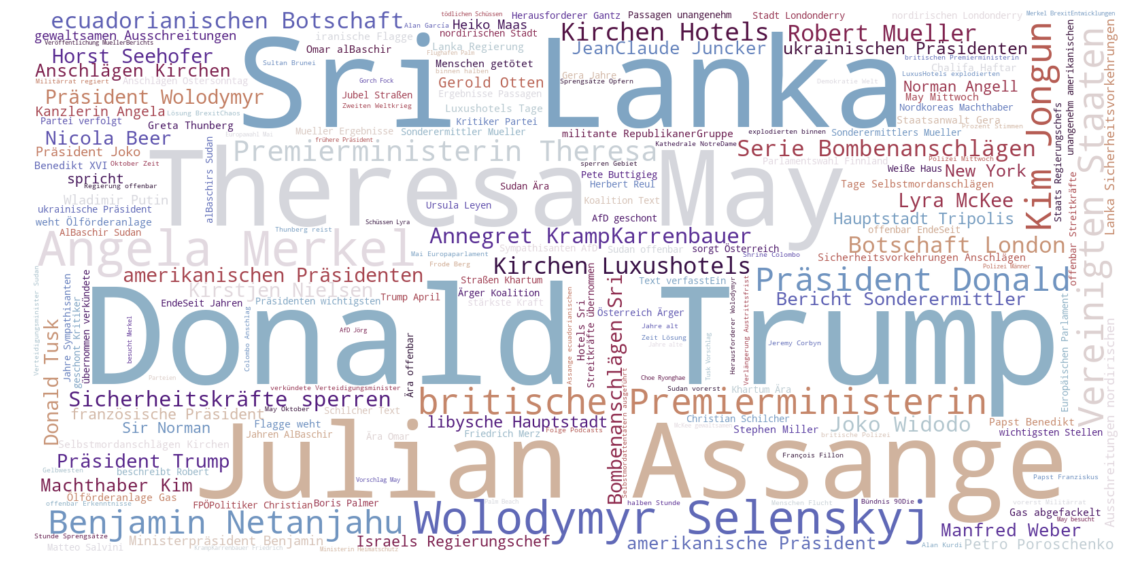

In [34]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords=stopwordlist, background_color='white', colormap='twilight').generate(pol_text)
plt.figure(figsize=(20,10), )
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.show()

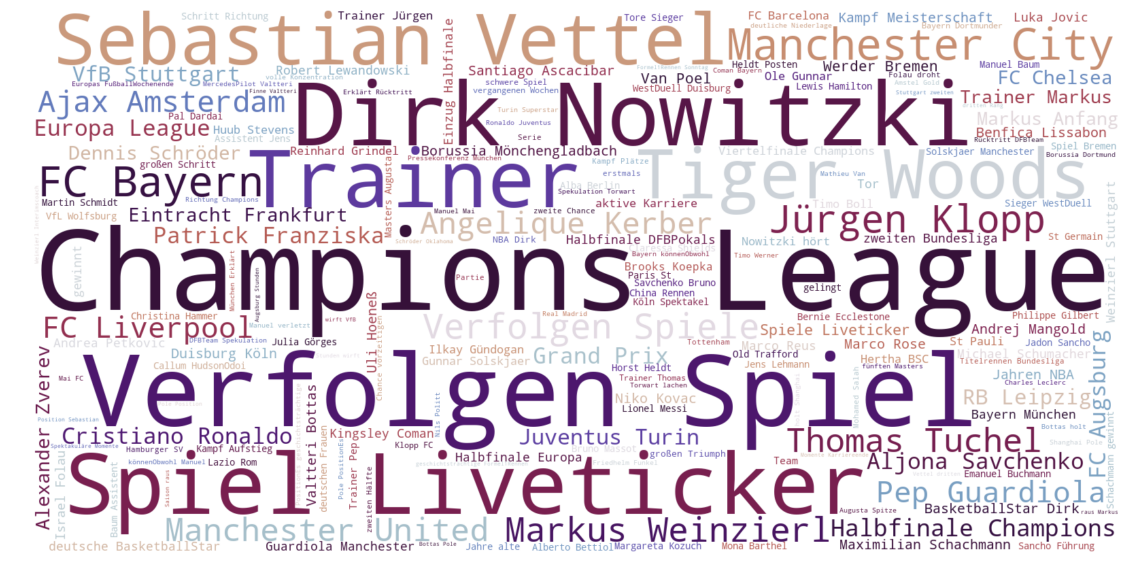

In [35]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords=stopwordlist, background_color='white', colormap='twilight').generate(sport_text)
plt.figure(figsize=(20,10), )
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.show()

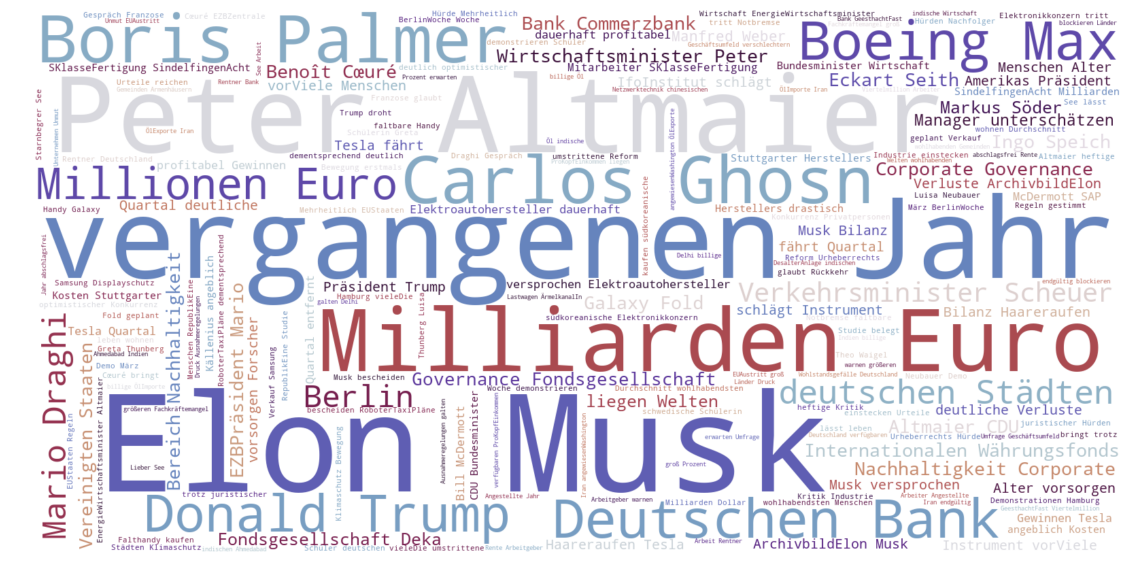

In [36]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords=stopwordlist, background_color='white', colormap='twilight').generate(eco_text)
plt.figure(figsize=(20,10), )
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.show()

---

### Test the model with a randomly generated text:

In [37]:
sample = []

samples = utils.test_tables('aktuell')
sample.append(samples)

faz_sample = pd.concat(sample, axis=0, ignore_index=True)
faz_sample = faz_sample.drop_duplicates()

In [38]:
faz_samples = faz_sample.drop(columns=['link', 'published','title','label'])
details = faz_samples['detailed']
sample_text = details.values.tolist()

In [39]:
sample = random.choice(sample_text)
print(sample)
print('\n')

exemp = sample.lower()
test_article = tf_vector.transform([exemp])
pred = lclf.predict(test_article)

if pred == 1:
    print('The above text belongs to the category: "Politik"')
    
elif pred == 2:
    print('The above text belongs to the category: "Sport"')
    
elif pred == 3:
    print('The above text belongs to the category: "Wirtschaft"')
    
elif pred == 4:
    print('The above text belongs to the category: "Feuilleton"')
    
elif pred == 5:
    print('The above text belongs to the category: "Finanzen"')
    
elif pred == 6:
    print('The above text belongs to the category: "Gesellschaft"')
    
else:
    print('The above text belongs to one of these categories: "Beruf-Chance", "Reise", "Stil", "Motor" or "Wissen" .')

Blick auf das neue Nationalmuseum von Katar am Eröffnungstag. Es ist einer Wüstenrose nachempfunden.In Qatars Hauptstadt Doha, wo in drei Jahren die Fußball-WM stattfindet, eröffnet das erste Nationalmuseum des 21. Jahrhunderts – und stellt die Frage, ob man heute noch national bauen kann.


The above text belongs to the category: "Sport"


---